In [ ]:
!pip install tensorly

     |████████████████████████████████| 160 kB 4.2 MB/s 
     |████████████████████████████████| 154 kB 24.6 MB/s 


In [3]:
import numpy as np
import json
import matplotlib.pyplot as plt

# Data Import

In [12]:
with open('/content/drive/MyDrive/UCLA REU 2021 KG /Topic Modeling/NMF/NMF_data.json','r') as file:
  data = json.load(file)

## DateTime

In [4]:
from datetime import datetime as dt
from datetime import timedelta as td
def timestampToText(timestamp:str):
  return timestamp[4:11]+timestamp[-4:]

def timestampToDT(timestamp:str):
  return dt.strptime(timestampToText(timestamp),'%b %d %Y')

In [13]:
times = []
for tweet in data:
  t = timestampToDT(tweet['timestamp'])
  tweet['time'] = t
  if not (t in times):
    times.append(t)

print(len(times))
print(times) # should be sorted already

464
[datetime.datetime(2020, 3, 11, 0, 0), datetime.datetime(2020, 3, 12, 0, 0), datetime.datetime(2020, 3, 13, 0, 0), datetime.datetime(2020, 3, 14, 0, 0), datetime.datetime(2020, 3, 15, 0, 0), datetime.datetime(2020, 3, 16, 0, 0), datetime.datetime(2020, 3, 17, 0, 0), datetime.datetime(2020, 3, 18, 0, 0), datetime.datetime(2020, 3, 19, 0, 0), datetime.datetime(2020, 3, 20, 0, 0), datetime.datetime(2020, 3, 21, 0, 0), datetime.datetime(2020, 3, 22, 0, 0), datetime.datetime(2020, 3, 23, 0, 0), datetime.datetime(2020, 3, 24, 0, 0), datetime.datetime(2020, 3, 25, 0, 0), datetime.datetime(2020, 3, 26, 0, 0), datetime.datetime(2020, 3, 27, 0, 0), datetime.datetime(2020, 3, 28, 0, 0), datetime.datetime(2020, 3, 29, 0, 0), datetime.datetime(2020, 3, 30, 0, 0), datetime.datetime(2020, 3, 31, 0, 0), datetime.datetime(2020, 4, 1, 0, 0), datetime.datetime(2020, 4, 2, 0, 0), datetime.datetime(2020, 4, 3, 0, 0), datetime.datetime(2020, 4, 4, 0, 0), datetime.datetime(2020, 4, 5, 0, 0), datetime.dat

# Data slice

## Slice by tweets

In [17]:
slice_size = 2000
tweet_slices = [data[i:i+slice_size] for i in range(0, len(data), slice_size)][:-1]

# TFIDF

In [25]:
n_components = 20
n_top_words = 20

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(df:list,vocab=None):
  docs = [tweet['cleaned_text'] for tweet in df]
  texts = docs
  vectorizer = TfidfVectorizer(vocabulary=vocab)

  for i in range(len(texts)):
    texts[i] = ' '.join(texts[i])

  return vectorizer.fit_transform(texts)
  # [vectorizer.fit_transform(texts),vectorizer.get_feature_names()]

def vocabFromTweets(df:list,max_df=1.0, min_df=1, ngram_range=(1, 1)):
  docs = [tweet['cleaned_text'] for tweet in df]
  texts = docs
  vectorizer = TfidfVectorizer(min_df=min_df,max_df=max_df,ngram_range=ngram_range)

  for i in range(len(texts)):
    texts[i] = ' '.join(texts[i])

  vectorizer.fit_transform(texts)
  return vectorizer.vocabulary_

def formatTopic(event:list,fnames:list,nTopTags:int=n_top_words):
  hashtags = [[fnames[i],np.abs(event[i])] for i in range(len(event)) if event[i]!=0]
  hashtags.sort(key=lambda x:x[1],reverse=True)
  hashtags = hashtags[:nTopTags] if nTopTags else hashtags
  return {x[0]:x[1] for x in hashtags}

def outfilename(fname:str):
  return '/content/drive/MyDrive/UCLA REU 2021 KG /Topic Modeling/NCPD/'+fname

def outfile(fname:str):
  return open('/content/drive/MyDrive/UCLA REU 2021 KG /Topic Modeling/NCPD/'+fname,'w')

def plot_top_words_dict(topics, title, save=False):
  fig, axes = plt.subplots(n_components//5, 5, figsize=(50, int(1.5*n_components)), sharex=True) # change num of topics?
  axes = axes.flatten()
  indx = 0 # topic index
  for topic in topics:
    keywords = list(topic)
    weights = [topic[word] for word in keywords]

    ax = axes[indx]
    ax.barh(keywords, weights, height=0.7)
    ax.set_title(f'Topic {indx}',
                  fontdict={'fontsize': 30})
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=20)
    for i in 'top right left'.split():
        ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=40)
    indx+=1
  if save:
    plt.savefig('/content/drive/MyDrive/UCLA REU 2021 KG /Topic Modeling/NCPD/'+title+'.png')

## From File

In [ ]:
with open(outfilename('complete_kw.json')) as file:
  voc = json.load(file)

# NCPD

In [ ]:
tf_results = [tfidf(day,voc) for day in tweet_slices]

In [ ]:
print(len(tf_results))

306


In [ ]:
nSlices = len(tf_results)
tf_data= tf_results[:nSlices]

## Sparse operations

In [ ]:
!pip install sparse
import sparse

     |████████████████████████████████| 76 kB 2.7 MB/s 


In [ ]:
from tensorly.contrib.sparse.decomposition import non_negative_parafac,parafac
from tensorly.contrib.sparse.cp_tensor import cp_to_tensor
from tensorly.contrib.sparse import tensor
import tensorly.contrib.sparse as stl

In [ ]:
def sparseItr(mats:list): # list of csr matrices
  result = list()
  for i in range(len(mats)):
    m = mats[i]
    nz = m.nonzero()
    row = nz[0]
    col = nz[1]
    for l in range(len(row)):
      j = row[l]
      k = col[l]
      yield ((i,j,k),m[j,k])

In [ ]:
def factorTensor(slices:int=nSlices):
  tf = sparse.COO(coords=sparseItr(tf_results[:slices]),shape=(slices,slice_size,len(voc)))
  return non_negative_parafac(tensor(tf),rank=n_components, init='random')
# 1st line Time for whole dataset (2k slice size, 1.8k keywords): 2min
### 2nd line time: shape=(30, 1835, 1827)->18m2s

import os


def save(factors,slices:int=nSlices): # file name indicates (rank,slices/total slices)
  time_topic = factors[1][0]
  topic_tweet = factors[1][1].transpose()
  topic_kw = factors[1][2].transpose()

  folder = 're('+str(n_components)+','+str(slices)+'-'+str(len(tf_results))+')'
  os.makedirs(outfilename(folder), exist_ok=True)

  with outfile(folder+'/slice_topic.json') as file:
    json.dump(time_topic.todense().tolist(),file)

  with outfile(folder+'/topic_tweet.json') as file:
    json.dump(topic_tweet.todense().tolist(),file)

  with outfile(folder+'/topic_kw.json') as file:
    json.dump(topic_kw.todense().tolist(),file)

  # with outfile('wordlist.json') as file:
  #   json.dump(voclist,file)

  voc.sort()
  topics = [formatTopic(event,voc) for event in topic_kw]
  with outfile(folder+'/topics.json') as file:
    json.dump(topics,file)


In [ ]:
nSlices = len(tf_results)
fctr2 = factorTensor(nSlices)
# Time: ~0.5h/30 slices, 20 topics
# ~2.5h/306,20
# /306,100

In [ ]:
save(fctr2,nSlices)

'' was not found in history, as a file, url, nor in the user namespace.


# Save and Interpret Results

In [ ]:
time_topic = fctr2[1][0]
topic_tweet = fctr2[1][1].transpose()
topic_kw = fctr2[1][2].transpose()

In [ ]:
voc.sort()
topics = [formatTopic(event,voc) for event in topic_kw]

In [ ]:
with outfile('topic_time.json') as file:
  json.dump(topic_time.tolist(),file)

# with outfile('topic_tweet.json') as file:
#   json.dump(topic_tweet.tolist(),file)

with outfile('topic_kw.json') as file:
  json.dump(topic_kw.tolist(),file)

with outfile('wordlist.json') as file:
  json.dump(voclist,file)

with outfile('topics.json') as file:
  json.dump(topics,file)

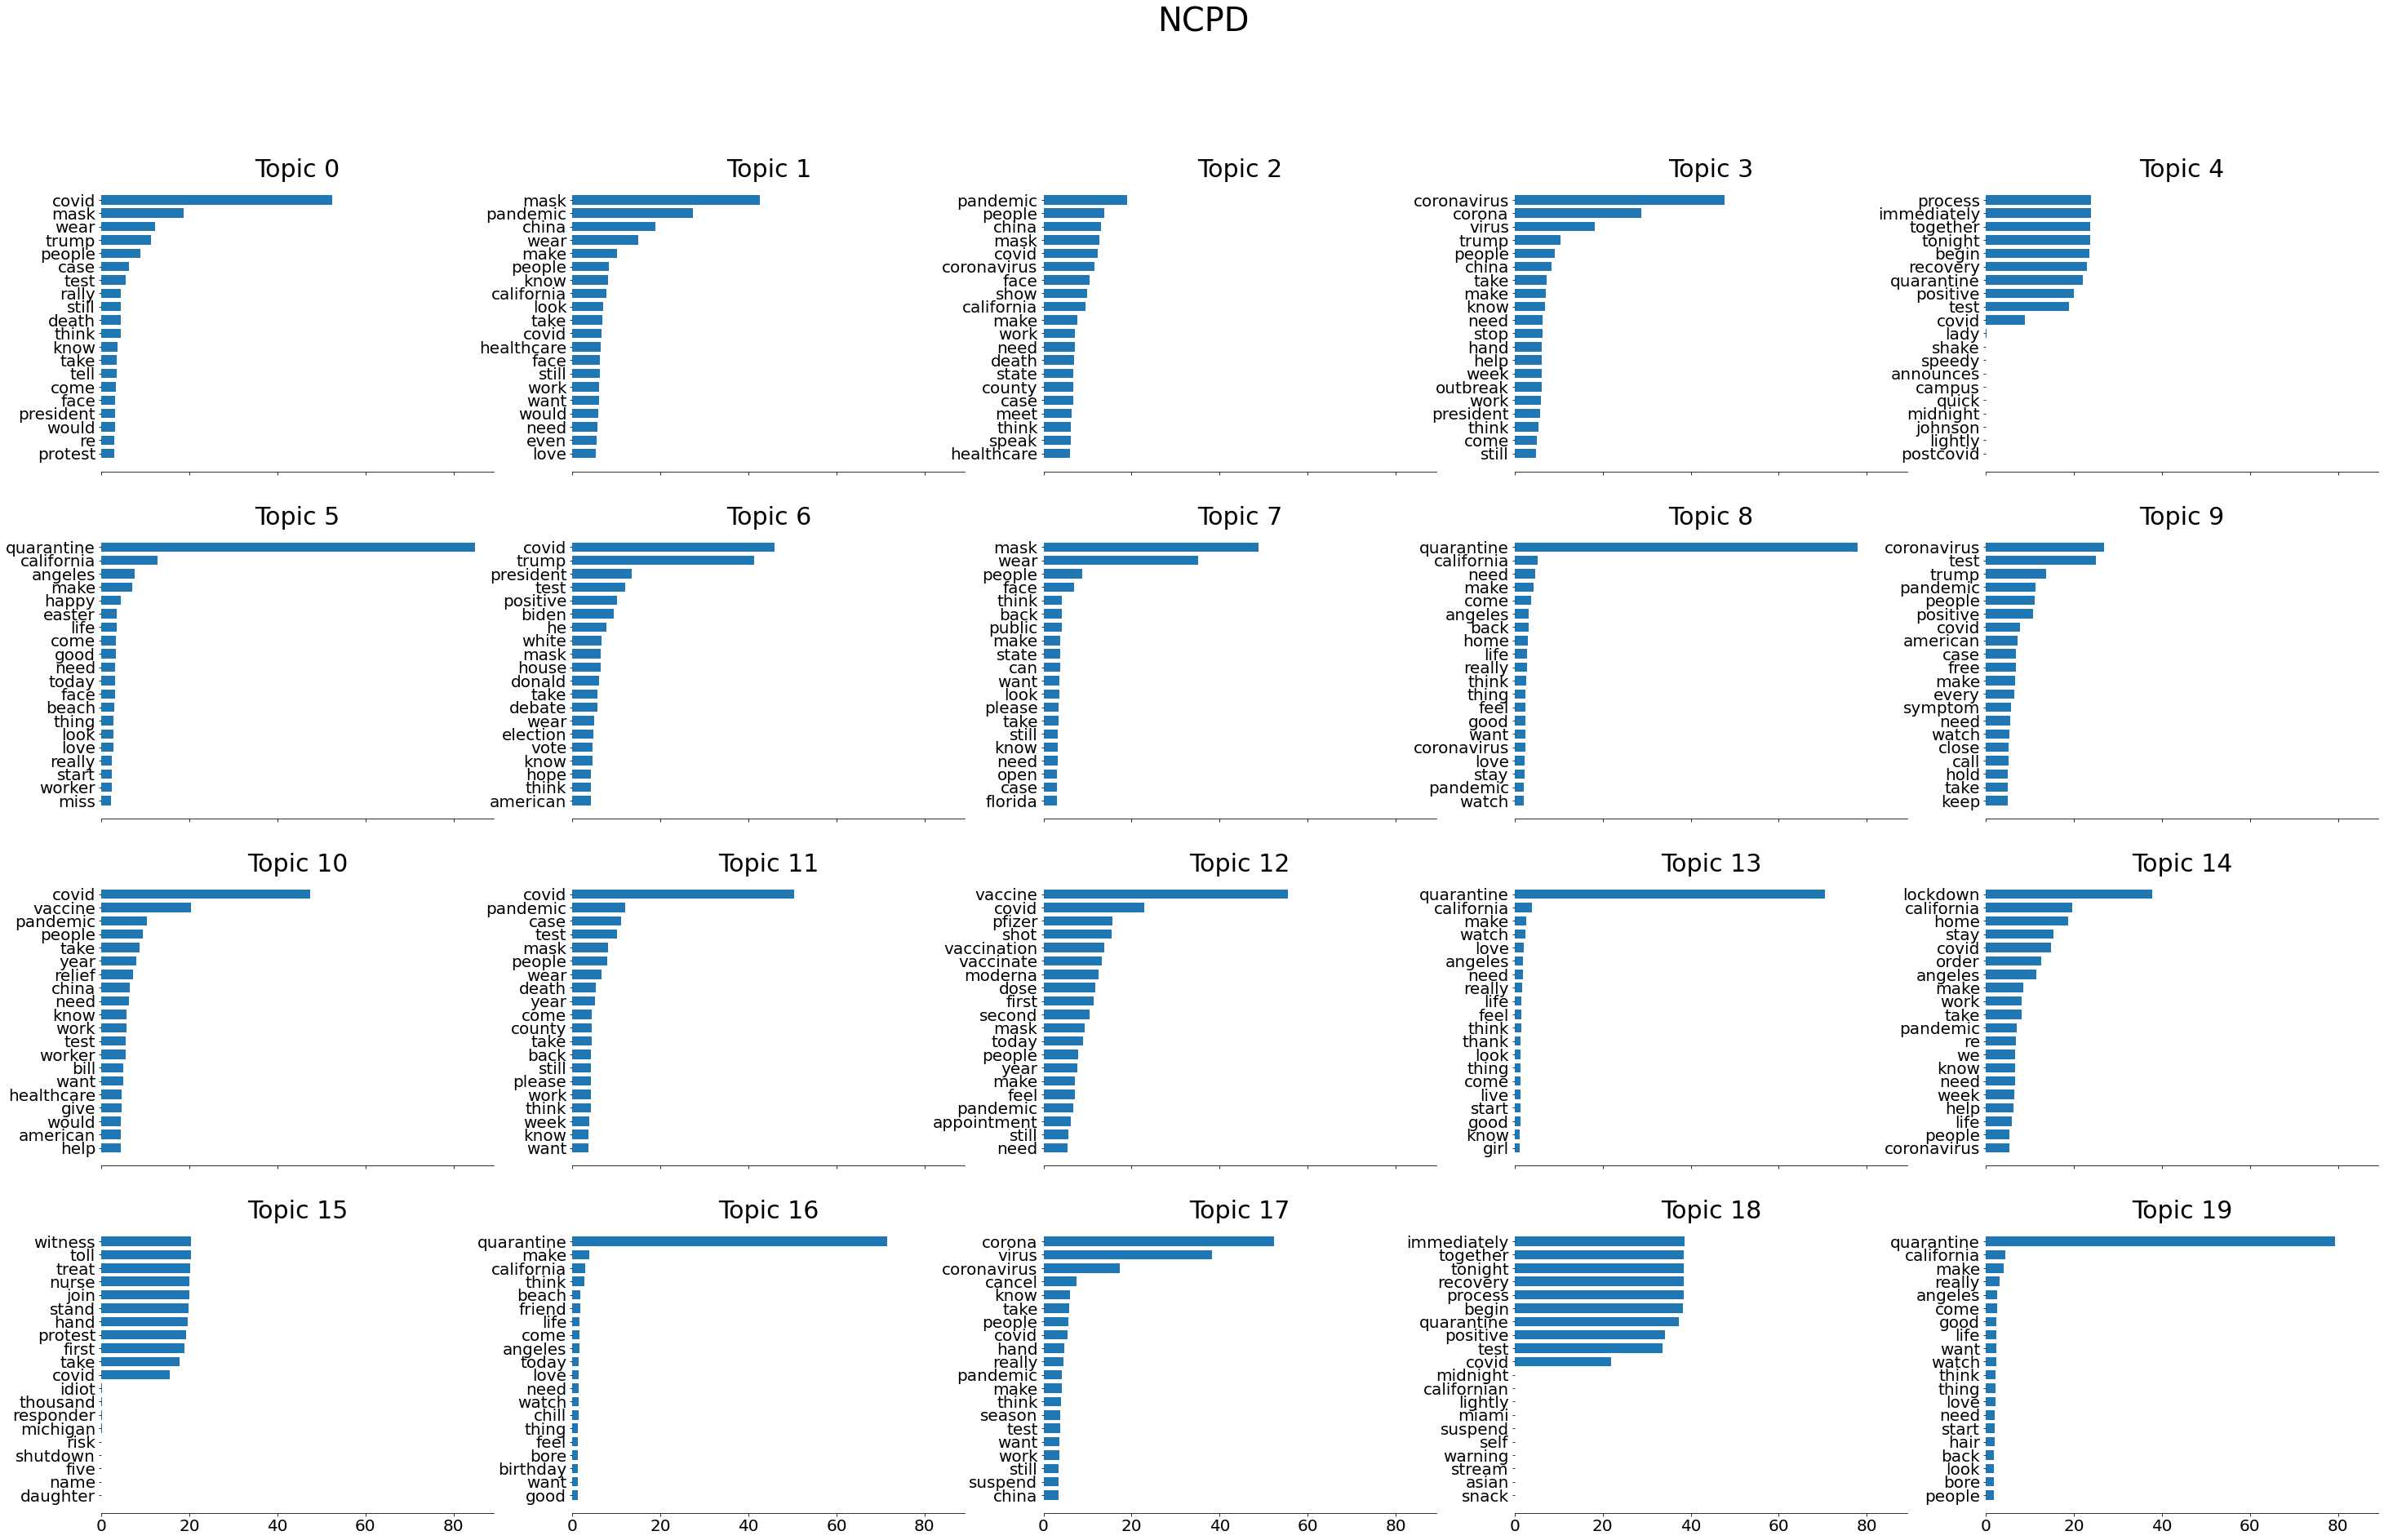

In [ ]:
plot_top_words_dict(topics,'NCPD',True)
plt.savefig(outfilename('re_NCPD.png'))

# Animation

In [ ]:
print(topic_time.shape)
topic_names = ['Topic '+str(i) for i in range(n_components)]
if len(topic_time) == n_components:
  topic_time = topic_time.transpose()

(20, 30)


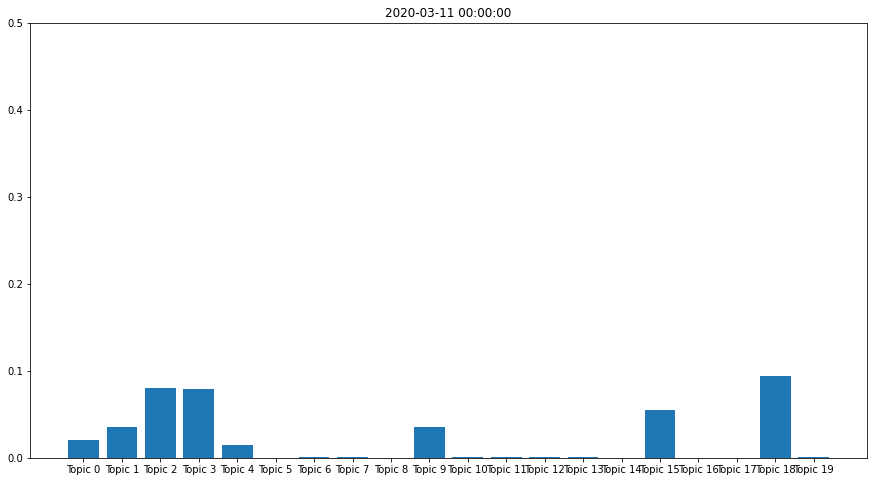

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(15, 8))

height = 0.5


def draw_barchart(day:int):
  plt.cla()
  distr = topic_time[day]
  ax.bar(topic_names, distr, animated=True)
  ax.set_ylim([0,height])
  plt.title(str(times[day]))

animator = FuncAnimation(fig, draw_barchart, frames=range(Days))
HTML(animator.to_html5_video())
animator.save(outfilename('NCPD.mp4'))

NameError: ignored

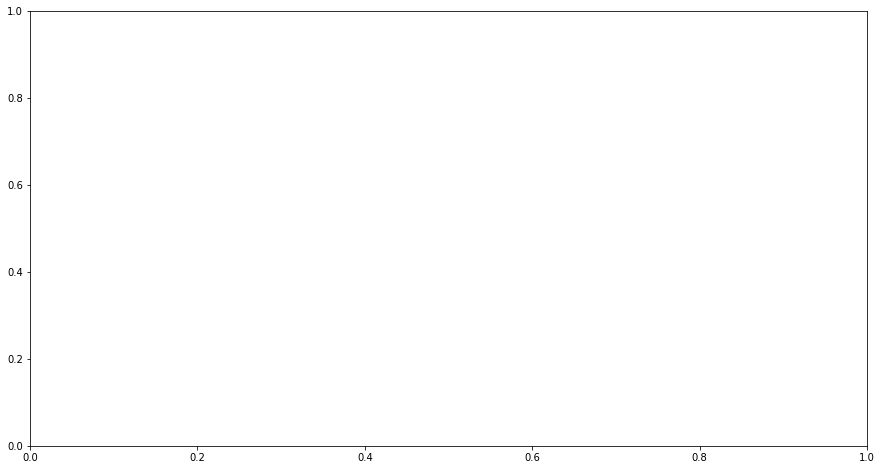

In [24]:
fig, ax = plt.subplots(figsize=(15, 8))

def normalize(x:list):
  s = sum(x)
  return [y/s for y in x] if s else x

normalized_distr = [normalize(x) for x in topic_time]

height = np.ceil(10*np.max([np.max(x) for x in normalized_distr]))*0.1+0.1
print(height)

# Interpolate by hour
def interpolate(start:list, end:list, curTime:int, totalTime:int):
  assert len(start)==len(end)
  a = curTime/totalTime
  b = 1-a
  return [b*start[i]+a*end[i] for i in range(len(start))]

interpolated = [interpolate(normalized_distr[i//24],normalized_distr[i//24+1],i%24,24) for i in range(24*(Days-1))]
baseTime = times[0]
titles = [str(baseTime+td(hours=i)) for i in range(len(interpolated))]

def draw_barchart(day:int):
  plt.cla()
  distr = interpolated[day]
  ax.bar(topic_names, distr, animated=True)
  ax.set_ylim([0,height])
  plt.title(titles[day])

animator = FuncAnimation(fig, draw_barchart, frames=range(len(interpolated)))
# HTML(animator.to_html5_video())
animator.save(outfilename('NCPD.mp4'),fps=24)

### Time: 122s

TODO: 
- normalize to tweet volume
- deal with downsampling (random?)
- expand time (timespan; use hour instead of interpolation) 
- [interpolation]

Meeting: 
- Sparse
  - Branching to solve vocab noise
- Slice size
- Heatmap


# Heatmap

In [1]:
from pandas import DataFrame
import seaborn as sns

In [26]:
def dtToStr(d:dt):
  return d.strftime('%y %b %d')

def normalize(x:list,max:float=1):
  s = sum(x)
  return [y*max/s for y in x] if s else x

# normalized_distr = [normalize(x,1) for x in time_topic]
with open(outfilename('(20,306-306)/slice_topic.json')) as file:  
  normalized_distr = [normalize(x,1) for x in json.load(file)]

In [27]:
Index = ['Topic '+str(i) for i in range(n_components)]
Cols = [dtToStr(t) for t in times]
df = DataFrame(index=Index,columns=Cols,dtype=float,data=0)

In [28]:
print(df)

          20 Mar 11  20 Mar 12  20 Mar 13  ...  21 Jun 15  21 Jun 16  21 Jun 17
Topic 0         0.0        0.0        0.0  ...        0.0        0.0        0.0
Topic 1         0.0        0.0        0.0  ...        0.0        0.0        0.0
Topic 2         0.0        0.0        0.0  ...        0.0        0.0        0.0
Topic 3         0.0        0.0        0.0  ...        0.0        0.0        0.0
Topic 4         0.0        0.0        0.0  ...        0.0        0.0        0.0
Topic 5         0.0        0.0        0.0  ...        0.0        0.0        0.0
Topic 6         0.0        0.0        0.0  ...        0.0        0.0        0.0
Topic 7         0.0        0.0        0.0  ...        0.0        0.0        0.0
Topic 8         0.0        0.0        0.0  ...        0.0        0.0        0.0
Topic 9         0.0        0.0        0.0  ...        0.0        0.0        0.0
Topic 10        0.0        0.0        0.0  ...        0.0        0.0        0.0
Topic 11        0.0        0.0        0.

In [29]:
daysToSlices = {col:{} for col in Cols}
for i in range(len(tweet_slices)):
  for tweet in tweet_slices[i]:
    dct = daysToSlices[dtToStr(tweet['time'])]
    if i in dct:
      dct[i] += 1
    else:
      dct[i] = 1

In [30]:
print(daysToSlices)

{'20 Mar 11': {0: 2000, 1: 255}, '20 Mar 12': {1: 1745, 2: 2000, 3: 2000, 4: 2000, 5: 298}, '20 Mar 13': {5: 1702, 6: 2000, 7: 2000, 8: 1561}, '20 Mar 14': {8: 439, 9: 2000, 10: 2000, 11: 1188}, '20 Mar 15': {11: 812, 12: 2000, 13: 2000, 14: 537}, '20 Mar 16': {14: 1463, 15: 2000, 16: 2000, 17: 1979}, '20 Mar 17': {17: 21, 18: 2000, 19: 2000, 20: 2000, 21: 1235}, '20 Mar 18': {21: 765, 22: 2000, 23: 2000, 24: 2000, 25: 441}, '20 Mar 19': {25: 1559, 26: 2000, 27: 2000, 28: 1555}, '20 Mar 20': {28: 445, 29: 2000, 30: 2000, 31: 2000, 32: 1777}, '20 Mar 21': {32: 223, 33: 2000, 34: 2000, 35: 2000, 36: 73}, '20 Mar 22': {36: 1927, 37: 2000, 38: 2000, 39: 61}, '20 Mar 23': {39: 1939, 40: 2000, 41: 1892}, '20 Mar 24': {41: 108, 42: 2000, 43: 2000, 44: 1597}, '20 Mar 25': {44: 403, 45: 2000, 46: 2000, 47: 811}, '20 Mar 26': {47: 1189, 48: 2000, 49: 2000, 50: 35}, '20 Mar 27': {50: 1965, 51: 2000, 52: 1244}, '20 Mar 28': {52: 756, 53: 2000, 54: 1924}, '20 Mar 29': {54: 76, 55: 2000, 56: 2000, 5

In [31]:
print(len(normalized_distr[-1]))

20


In [32]:
for day in daysToSlices:
  slices = daysToSlices[day]
  for i in slices:
    n = slices[i]
    delta_df = DataFrame(index=Index,columns=[day],dtype=float,
                         data=[x*n for x in normalized_distr[i]])
    df = df.add(delta_df,fill_value=0)

df = df.reindex(Cols, axis=1)
print(df)

            20 Mar 11    20 Mar 12  ...  21 Jun 16  21 Jun 17
Topic 0   1115.231180  4435.853520  ...        0.0        0.0
Topic 1     23.254610   170.957042  ...        0.0        0.0
Topic 2     27.298084    75.011256  ...        0.0        0.0
Topic 3     27.017686   106.070917  ...        0.0        0.0
Topic 4     12.975208    86.084377  ...        0.0        0.0
Topic 5      2.372269    32.302231  ...        0.0        0.0
Topic 6     49.797613   128.973816  ...        0.0        0.0
Topic 7      6.493909    49.532996  ...        0.0        0.0
Topic 8    322.908451   634.535520  ...        0.0        0.0
Topic 9    134.105688   381.798412  ...        0.0        0.0
Topic 10    29.049683     9.493159  ...        0.0        0.0
Topic 11     5.838820   111.710576  ...        0.0        0.0
Topic 12    48.926749   377.287924  ...        0.0        0.0
Topic 13     5.266832    89.403203  ...        0.0        0.0
Topic 14     7.282400    79.421380  ...        0.0        0.0
Topic 15

In [33]:
df = df.drop(columns=['21 Jun '+str(i) for i in range(12,18)]) # deal with tail problems

In [ ]:
df.to_json(outfile('hm_data.json'))

# Heatmap

In [34]:
!pip install seaborn
import seaborn as sns

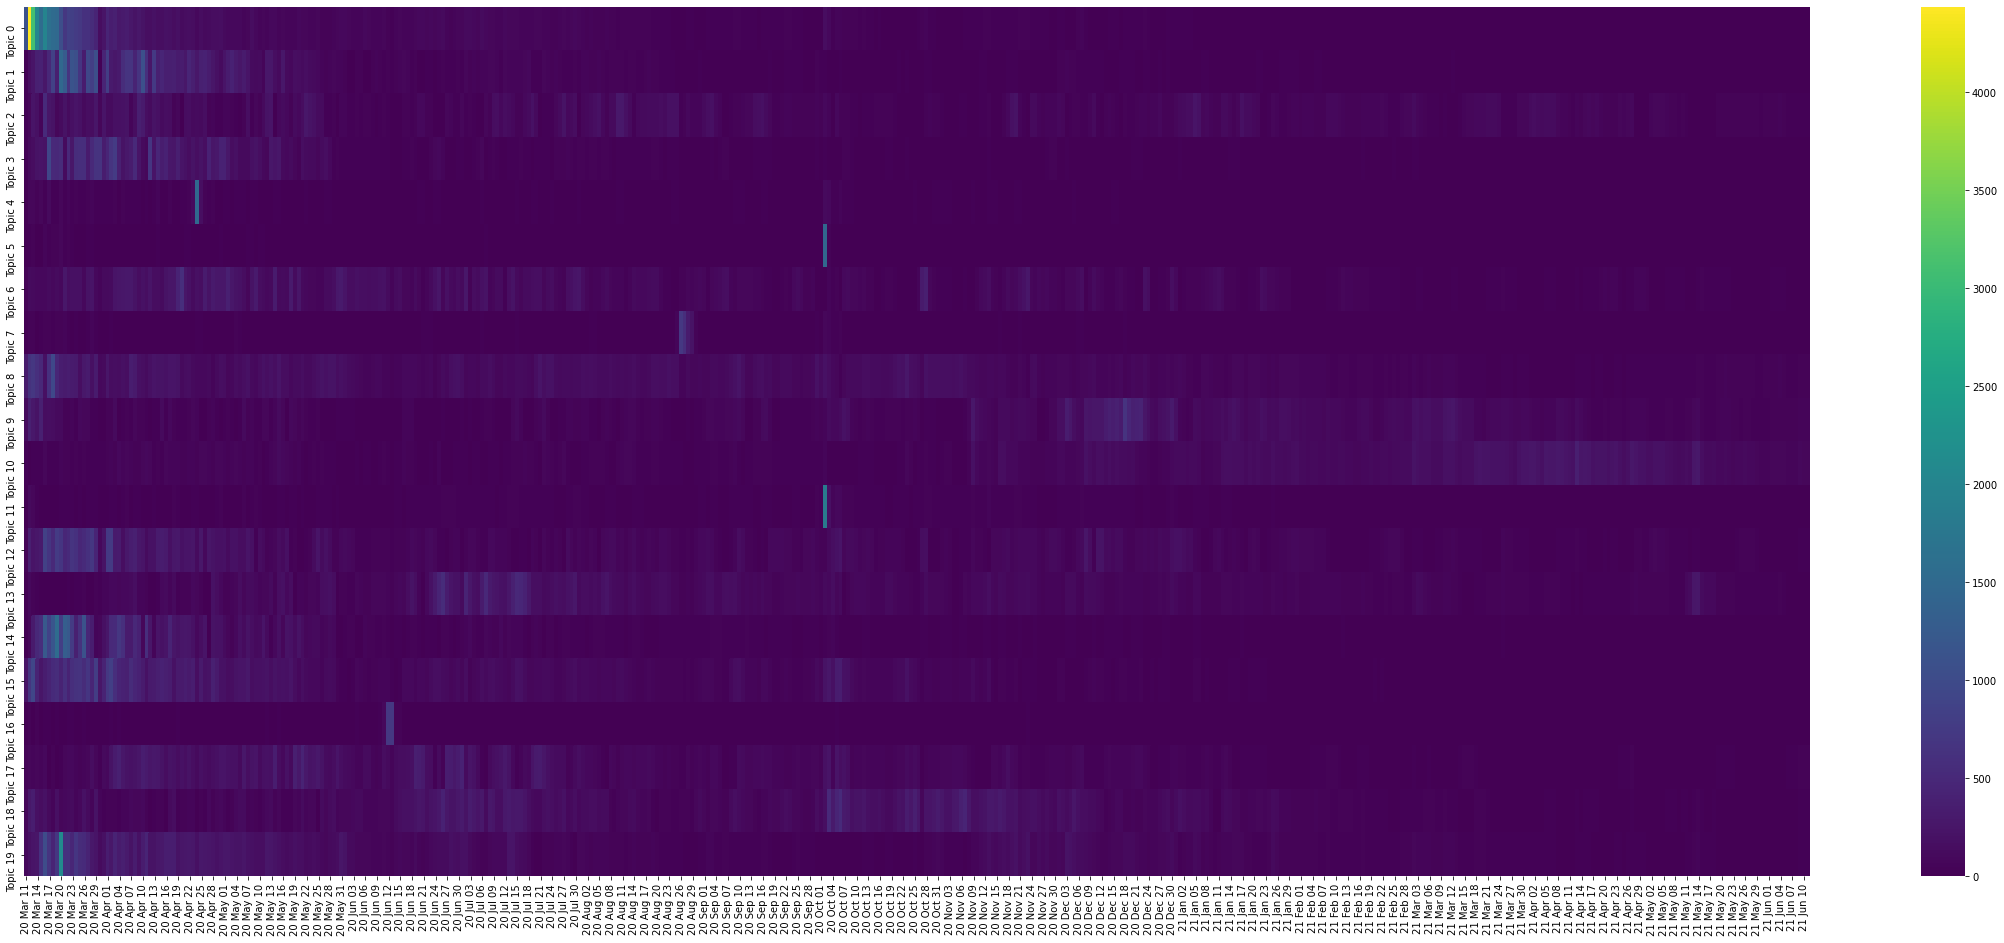

In [ ]:
fig, ax = plt.subplots(figsize=(40,16))
ax = sns.heatmap(df,cmap='viridis') # viridis, inferno, plasma
plt.savefig(outfilename('old_heatmap_all.png'))

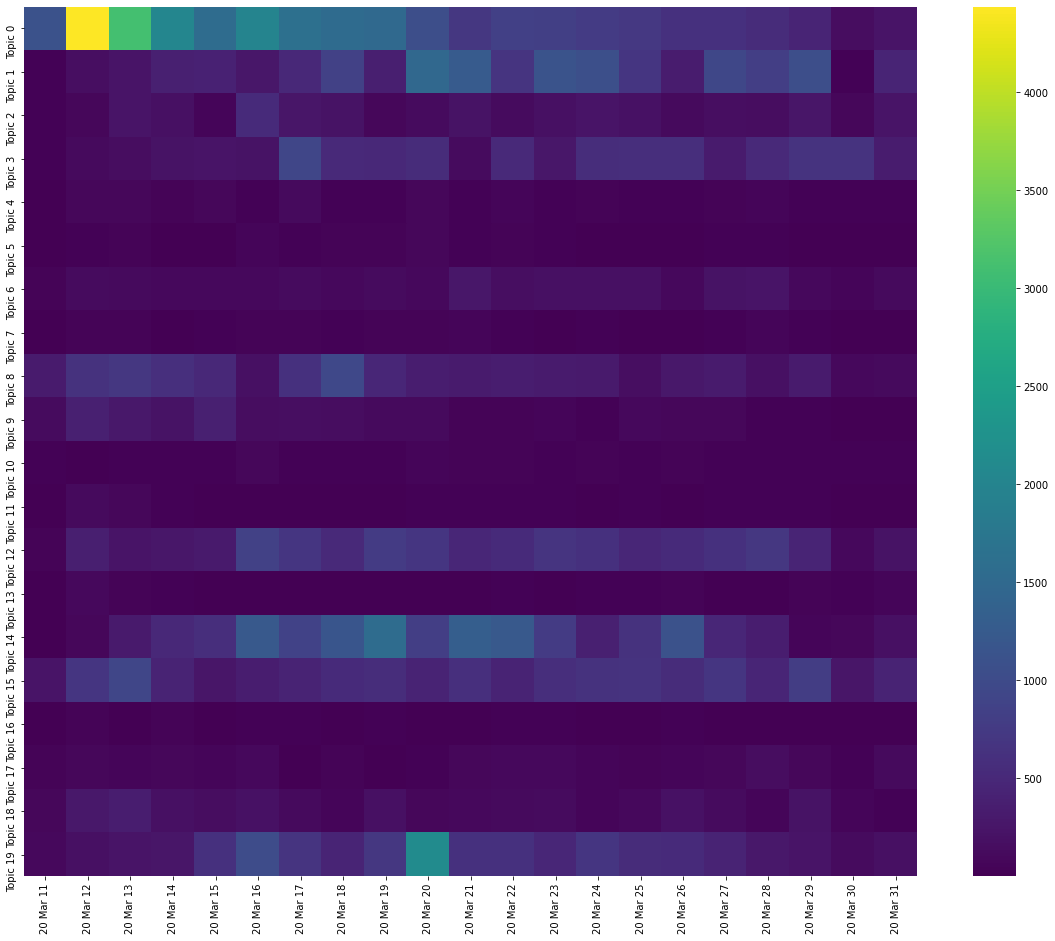

In [ ]:
Cols_Mar = Cols[:21]
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(df[Cols_Mar],cmap='viridis') # viridis, inferno, plasma
plt.savefig(outfilename('old_heatmap_March.png'))

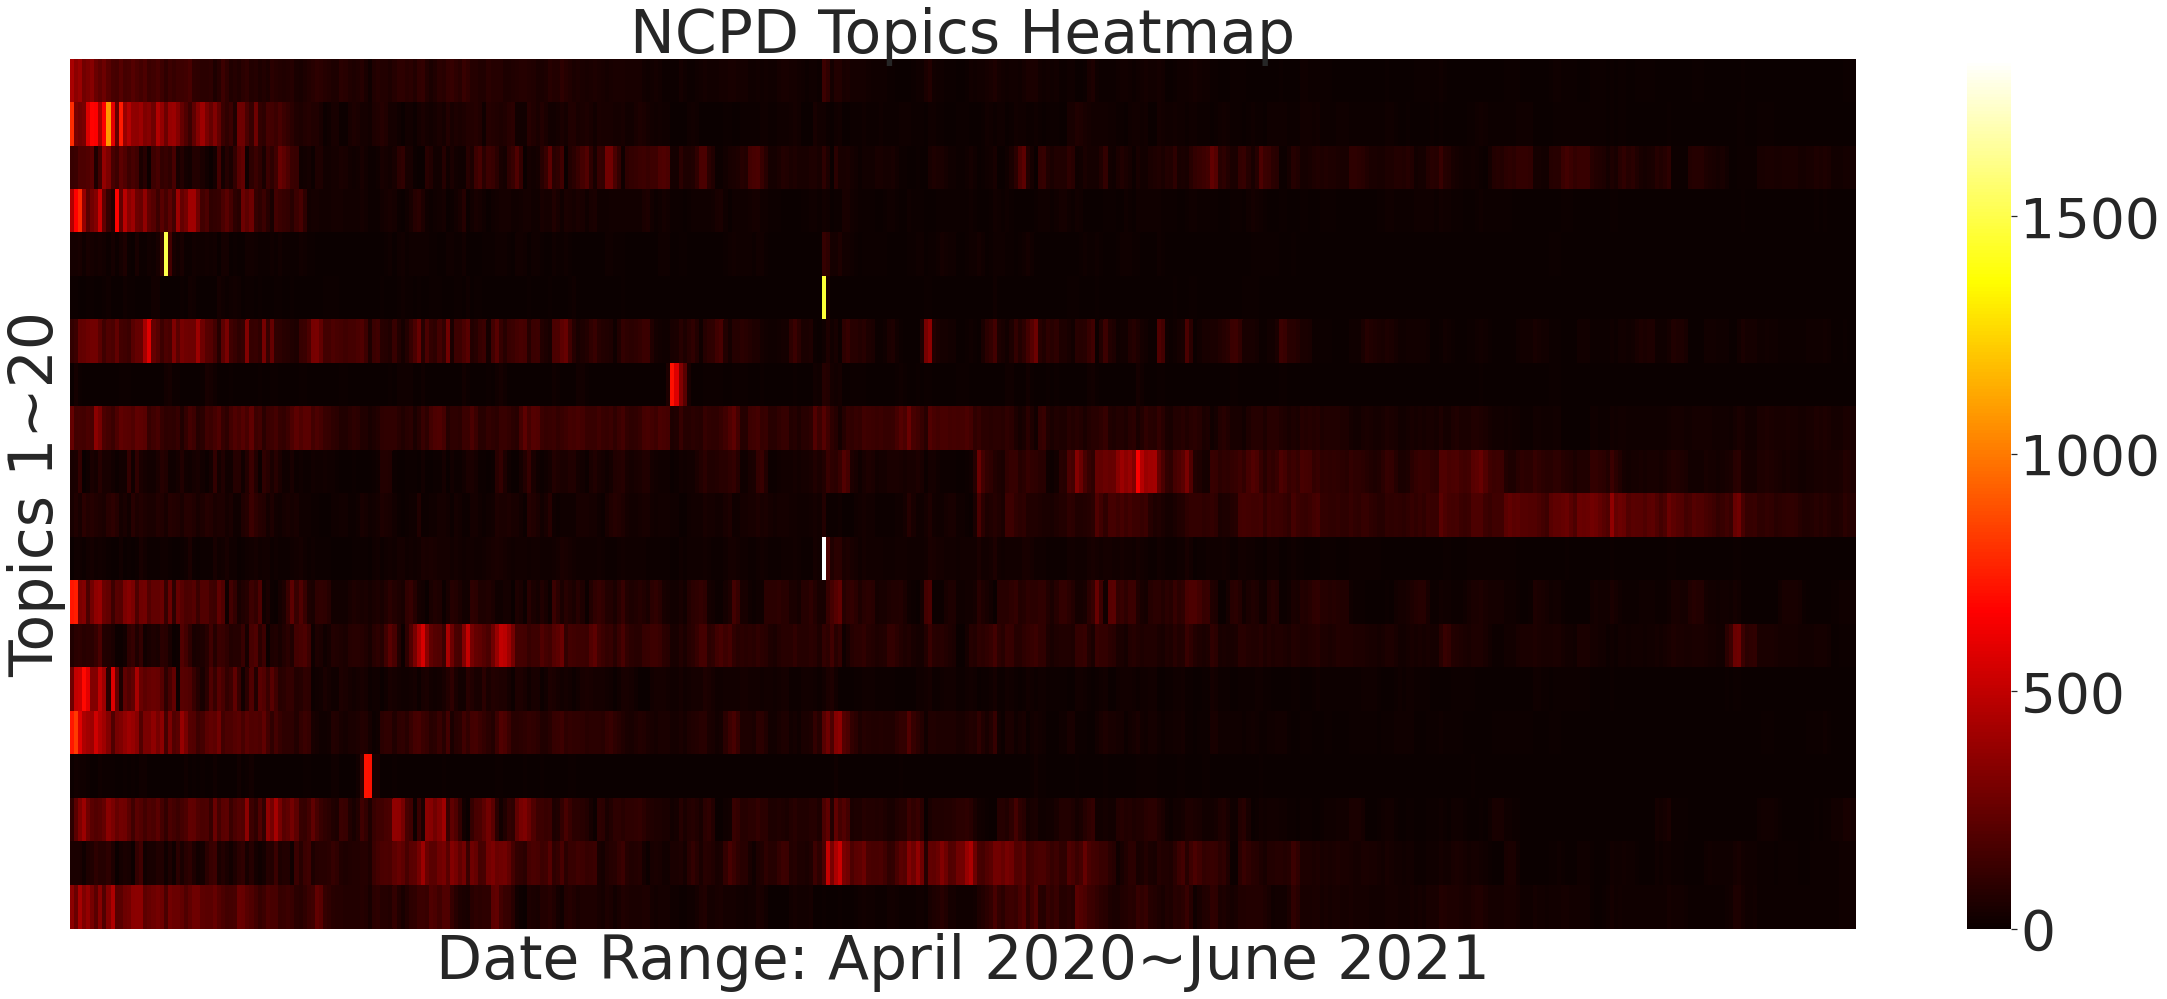

In [55]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(40,16))
ax = sns.heatmap(df[Cols[21:-6]],cmap='hot',xticklabels=False,yticklabels=False) # viridis, inferno, plasma
ax.set(title="NCPD Topics Heatmap",xlabel="Date Range: April 2020~June 2021",
      ylabel="Topics 1~20")
sns.set(font_scale=5)

plt.savefig(outfilename('test2.png'))

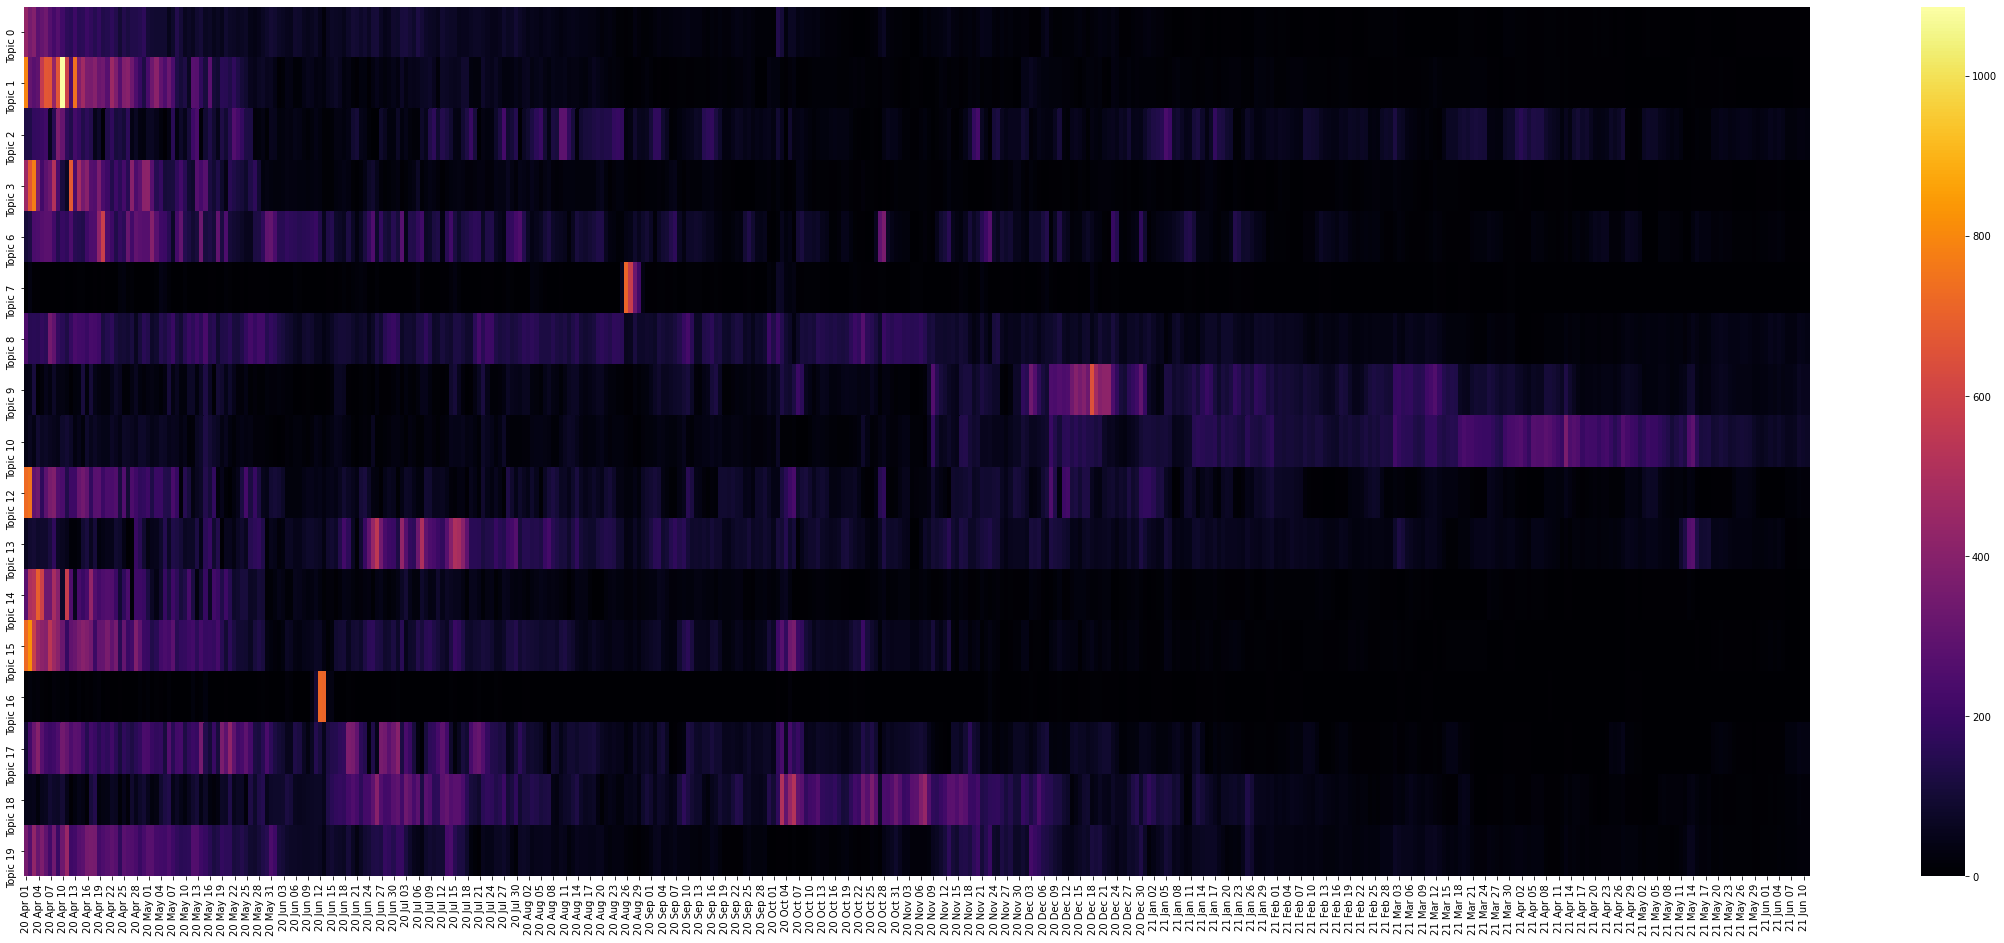

In [37]:
fig, ax = plt.subplots(figsize=(40,16))
ax = sns.heatmap(df[Cols[21:-6]].drop(index=['Topic 4','Topic 5','Topic 11']),cmap='inferno') # viridis, inferno, plasma
plt.savefig('test.png')

                     0         1  ...       304           305
Topic 0   4.746323e-01  0.650850  ...  0.019064  2.184712e-02
Topic 1   1.145483e-02  0.001353  ...  0.010274  1.695224e-02
Topic 2   1.286806e-02  0.006125  ...  0.146981  8.828753e-02
Topic 3   1.350652e-02  0.000018  ...  0.023153  1.826092e-03
Topic 4   5.630994e-03  0.006719  ...  0.000003  1.932368e-04
Topic 5   9.256032e-06  0.009230  ...  0.000003  2.494075e-04
Topic 6   2.483719e-02  0.000483  ...  0.058797  2.006955e-02
Topic 7   5.886825e-07  0.025462  ...  0.000017  2.075311e-06
Topic 8   1.495768e-01  0.093156  ...  0.145779  1.264314e-01
Topic 9   6.173522e-02  0.041707  ...  0.118310  1.691237e-01
Topic 10  1.428632e-02  0.001871  ...  0.225960  2.257575e-01
Topic 11  5.209524e-07  0.022893  ...  0.002773  1.235078e-02
Topic 12  2.115904e-02  0.025916  ...  0.010617  5.585304e-02
Topic 13  2.356213e-03  0.002174  ...  0.093929  2.722154e-02
Topic 14  2.394543e-03  0.009778  ...  0.018902  6.810709e-03
Topic 15

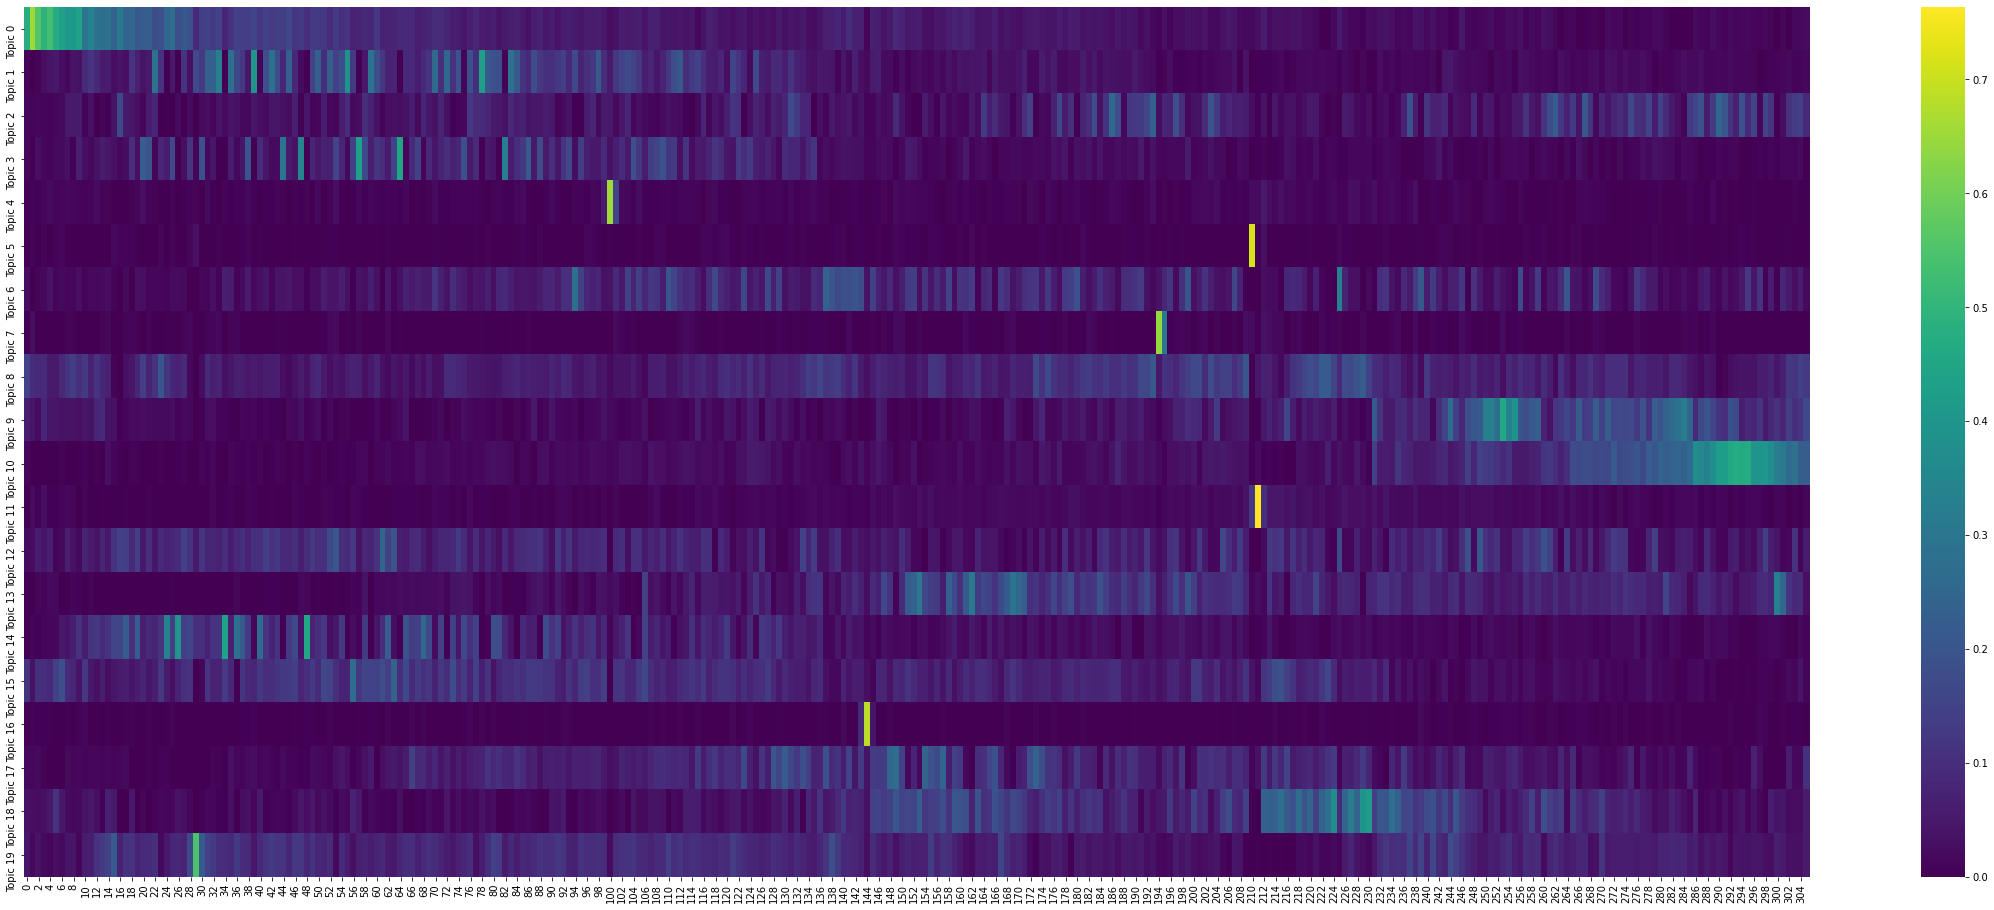

In [ ]:
df2 = DataFrame(data=np.array(normalized_distr).transpose(),index=Index,columns=[str(i) for i in range(nSlices)])
print(df2)

fig, ax = plt.subplots(figsize=(40,16))
ax = sns.heatmap(df2,cmap='viridis') # viridis, inferno, plasma
plt.savefig(outfilename('slice_heatmap.png'))

# Test

In [ ]:
for tweet in data:
  if 'orange' in tweet['text'] and (str(tweet['time'])=='2020-06-12 00:00:00'):
    print(tweet['time'],tweet['text'],'\n------------------')

2020-06-12 00:00:00 Let’s Go! I’m so hyped finally 

orange county covid death rate - 185 deaths out of 3.1 Million people.

time to open this bitch up! 
------------------
2020-06-12 00:00:00 orange county is lifting its face mask requirements and I work in a restaurant

ok 
------------------
2020-06-12 00:00:00 if i walk into a place without the must-have mask protocol....i will pull a karen bc “they just lost a customer” lol man fuck orange county :( 
------------------
